In [32]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

# Time series libraries for Forecasting
import time
t_start1 = time.perf_counter()

%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_pacf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


import warnings
warnings.filterwarnings("ignore")


MSEAS = 12                    # seasonality default
ALPHA = 0.05                  # significance level default 5 %

In [33]:
# Set plot size 
rcParams['figure.figsize'] = 10, 6

In [34]:
# Import Data
df = pd.read_csv('Month_Value_1.csv')
print('Shape of the data= ', df.shape)
print('Column datatypes= \n',df.dtypes)
df

Shape of the data=  (96, 5)
Column datatypes= 
 Period                                       object
Revenue                                     float64
Sales_quantity                              float64
Average_cost                                float64
The_average_annual_payroll_of_the_region    float64
dtype: object


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,1.601007e+07,12729.0,1257.763541,30024676.0
1,01.02.2015,1.580759e+07,11636.0,1358.507000,30024676.0
2,01.03.2015,2.204715e+07,15922.0,1384.697024,30024676.0
3,01.04.2015,1.881458e+07,15227.0,1235.606705,30024676.0
4,01.05.2015,1.402148e+07,8620.0,1626.621765,30024676.0
...,...,...,...,...,...
91,01.08.2022,NaN,NaN,NaN,NaN
92,01.09.2022,NaN,NaN,NaN,NaN
93,01.10.2022,NaN,NaN,NaN,NaN
94,01.11.2022,NaN,NaN,NaN,NaN


In [35]:
# Drop kolom yang tidak digunakan
df = df.drop(['Sales_quantity', 'Average_cost', 'The_average_annual_payroll_of_the_region'], axis=1)
df

,Period,Revenue
0,01.01.2015,1.601007e+07
1,01.02.2015,1.580759e+07
2,01.03.2015,2.204715e+07
3,01.04.2015,1.881458e+07
4,01.05.2015,1.402148e+07
...,...,...
91,01.08.2022,NaN
92,01.09.2022,NaN
93,01.10.2022,NaN
94,01.11.2022,NaN


In [36]:
# Drop row dengan value Nan
df.dropna(inplace=True)
df

,Period,Revenue
0,01.01.2015,1.601007e+07
1,01.02.2015,1.580759e+07
2,01.03.2015,2.204715e+07
3,01.04.2015,1.881458e+07
4,01.05.2015,1.402148e+07
...,...,...
59,01.12.2019,5.875647e+07
60,01.01.2020,5.628830e+07
61,01.02.2020,4.022524e+07
62,01.03.2020,5.002217e+07


In [37]:
# Jadikan 'Period' ke dalam format datetime dan sebagai index
df['Date'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
#df['Date'] = pd.to_datetime(df.Period)
df = df.set_index(df.Date)
df.drop(['Period', 'Date'], axis = 1, inplace = True)
print('Column datatypes= \n',df.dtypes)
df

Column datatypes= 
 Revenue    float64
dtype: object


,Revenue
Date,
2015-01-01,1.601007e+07
2015-02-01,1.580759e+07
2015-03-01,2.204715e+07
2015-04-01,1.881458e+07
2015-05-01,1.402148e+07
...,...
2019-12-01,5.875647e+07
2020-01-01,5.628830e+07
2020-02-01,4.022524e+07


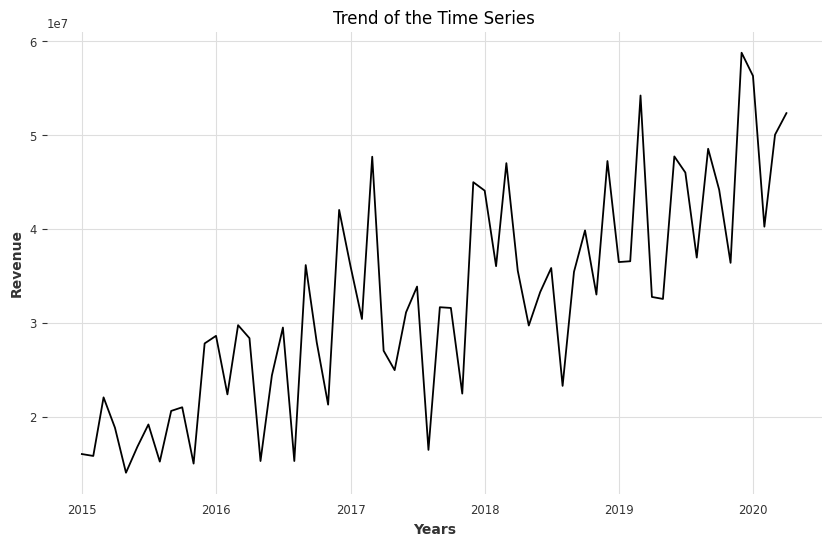

In [38]:
plt.figure(figsize= (10,6))
plt.plot(df)
plt.xlabel('Years')
plt.ylabel('Revenue')
plt.title('Trend of the Time Series')
plt.show()

Dari grafik di atas, terlihat ada trend naik untuk Revenue setiap tahunnya. 

### Seasonality
Tidak begitu jelas terlihat keberadaan seasonality, karena itu perlu dilakukan pengecekan lebih lanjut.

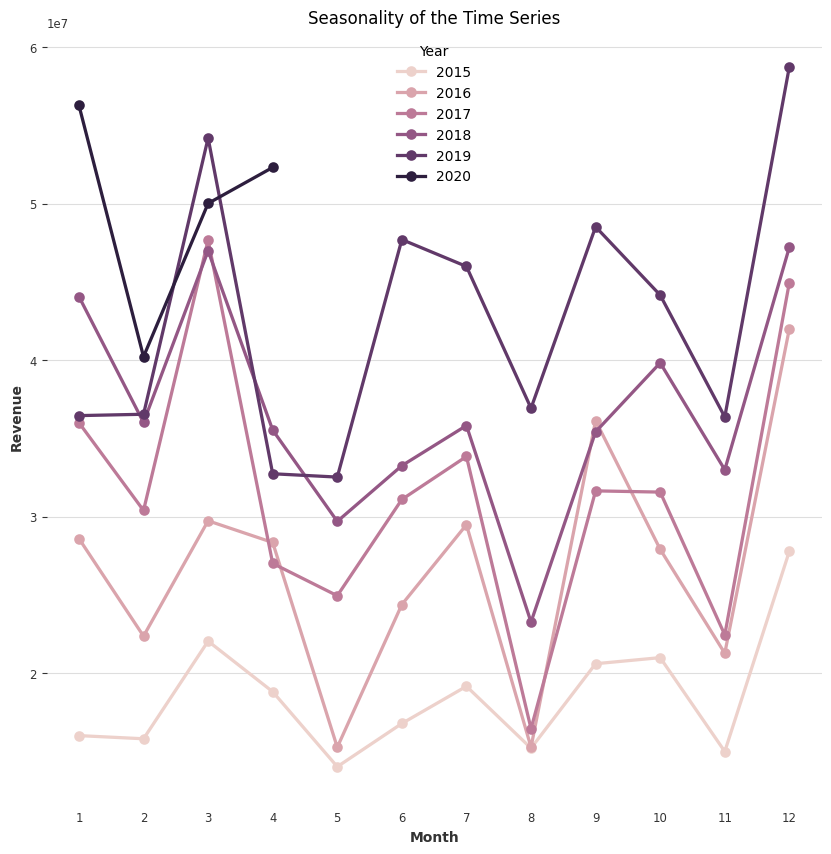

In [39]:
# Plot seasonality menggunakan dataframe sementara dengan menambahkan kolom untuk nilai Month and Year
df_temp = df.copy()
df_temp['Year'] = pd.DatetimeIndex(df_temp.index).year
df_temp['Month'] = pd.DatetimeIndex(df_temp.index).month

# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Seasonality of the Time Series')
sns.pointplot(x='Month',y='Revenue',hue='Year',data=df_temp)
plt.show()

In [40]:
df_ts = df.reset_index()
df_ts

,Date,Revenue
0,2015-01-01,1.601007e+07
1,2015-02-01,1.580759e+07
2,2015-03-01,2.204715e+07
3,2015-04-01,1.881458e+07
4,2015-05-01,1.402148e+07
...,...,...
59,2019-12-01,5.875647e+07
60,2020-01-01,5.628830e+07
61,2020-02-01,4.022524e+07
62,2020-03-01,5.002217e+07


In [62]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts import TimeSeries
ts = TimeSeries.from_dataframe(df_ts, time_col = 'Date', value_cols = 'Revenue')
series = ts

In [64]:
series

<TimeSeries (DataArray) (Date: 64, component: 1, sample: 1)> Size: 512B
array([[[16010072.1195  ]],

       [[15807587.449808]],

       [[22047146.023644]],

       [[18814583.29428 ]],

       [[14021479.611678]],

       [[16783928.522112]],

       [[19161892.194872]],

       [[15204984.296742]],

       [[20603939.9751  ]],

       [[20992874.780136]],

...

       [[45992141.57398 ]],

       [[36933665.022   ]],

       [[48526260.1344  ]],

       [[44160416.1824  ]],

       [[36374956.4944  ]],

       [[58756473.6608  ]],

       [[56288300.87    ]],

       [[40225243.264   ]],

       [[50022165.2325  ]],

       [[52320692.9428  ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 512B 2015-01-01 2015-02-01 ... 2020-04-01
  * component  (component) object 8B 'Revenue'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [65]:
# kita coba dari 2 sampai 50
for m in range(2, 50):
    is_seasonal, mseas = check_seasonality(ts, m=m, alpha=ALPHA)
    if is_seasonal == True:
        print('Seasonality Detected! Seasonal period = ', m)
        break

Seasonality Detected! Seasonal period =  3


Ditemukan seasonality period = 3.

### Decomposition of Time Series
Menggunakan teknik decomposition untuk membuat data menjadi beberapa komponen untuk visualisasi karakteristik time series.

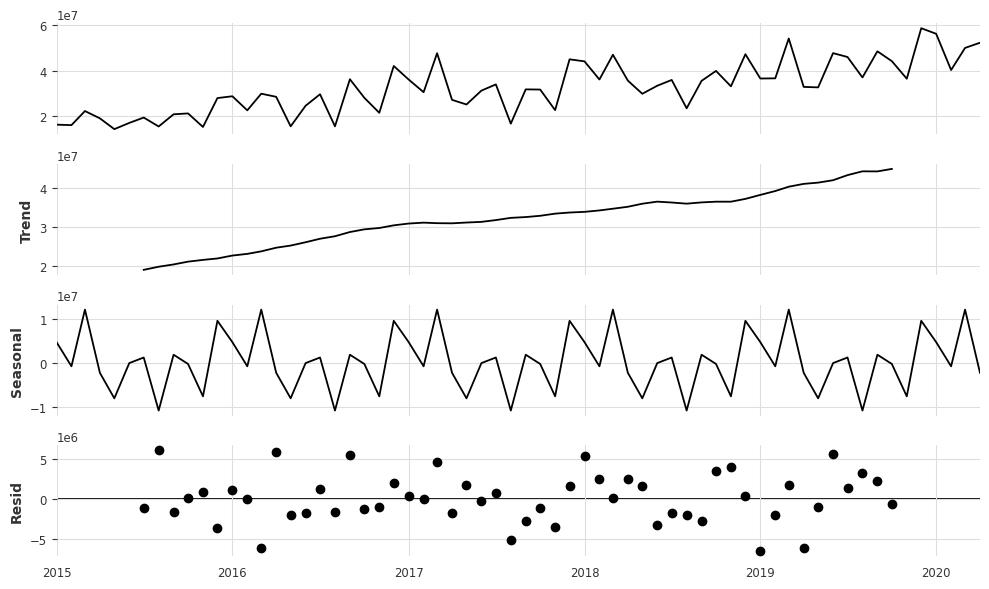

In [66]:
decomposition = sm.tsa.seasonal_decompose(df, model='additive') 
fig = decomposition.plot()
plt.show()

### Check for Stationarity
Menggunakan rolling statistics dan Dickey-Fuller test untuk cek stationarity data time series

In [67]:
def stationarity_test(timeseries):
    # Get rolling statistics for window = 12 i.e. yearly statistics
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    
    # Plot rolling statistic
    plt.figure(figsize= (10,6))
    plt.xlabel('Years')
    plt.ylabel('Revenue')    
    plt.title('Stationary Test: Rolling Mean and Standard Deviation')
    plt.plot(timeseries, color= 'blue', label= 'Original')
    plt.plot(rolling_mean, color= 'green', label= 'Rolling Mean')
    plt.plot(rolling_std, color= 'red', label= 'Rolling Std')   
    plt.legend()
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    df_test = adfuller(timeseries)
    df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)' %key] = value
    print(df_output)

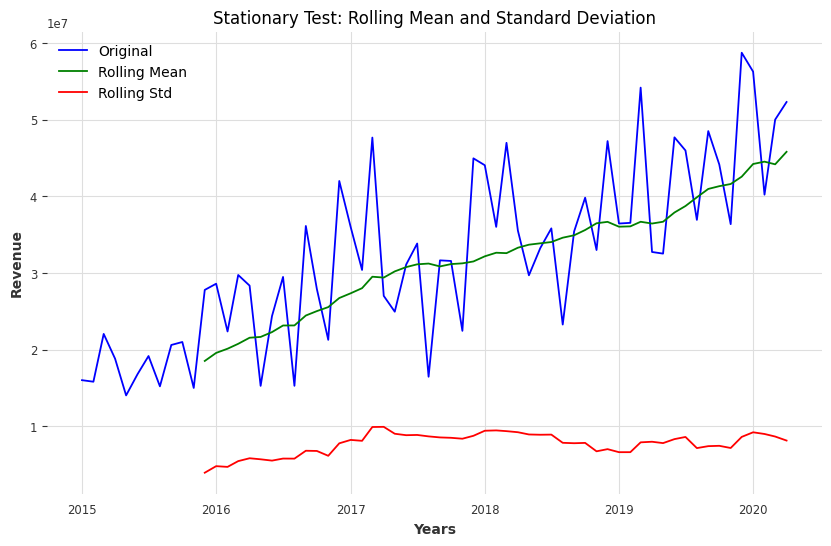

Results of Dickey-Fuller Test
Test Statistic                 -0.269149
p-value                         0.929762
#Lags Used                     11.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [68]:
# Tes stationarity score menggunakan data awal
stationarity_test(df)

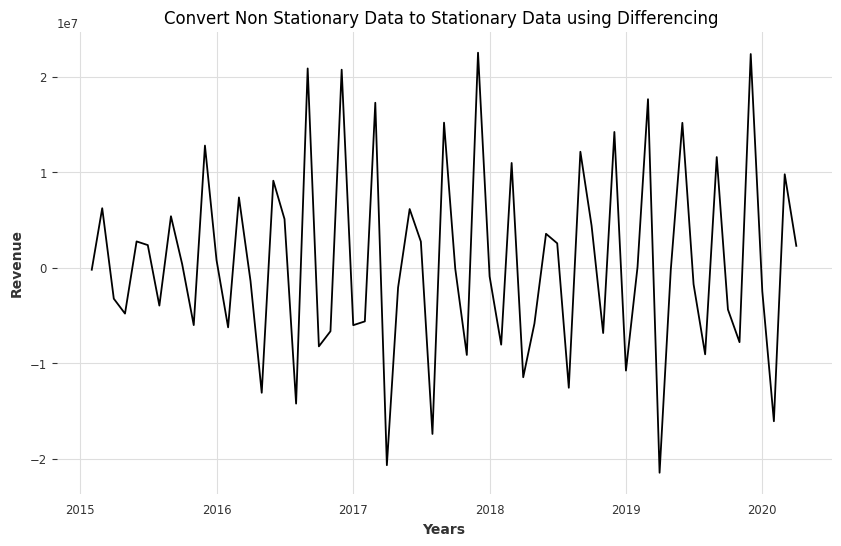

In [69]:
# Menggunakan differencing untuk menghilangkan trend
df_diff = df.diff(periods = 1) # First order differencing
plt.xlabel('Years')
plt.ylabel('Revenue')    
plt.title('Convert Non Stationary Data to Stationary Data using Differencing ')
plt.plot(df_diff)
plt.show()

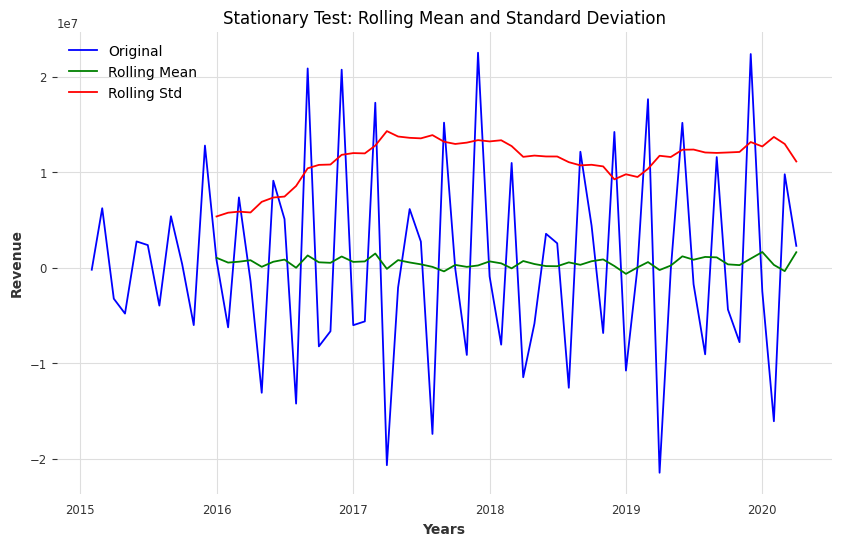

Results of Dickey-Fuller Test
Test Statistic                 -5.604330
p-value                         0.000001
#Lags Used                     10.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [70]:
# Menghilangkan data na yang mungkin disebabkan Data transformation
df_diff.dropna(inplace = True)
stationarity_test(df_diff)

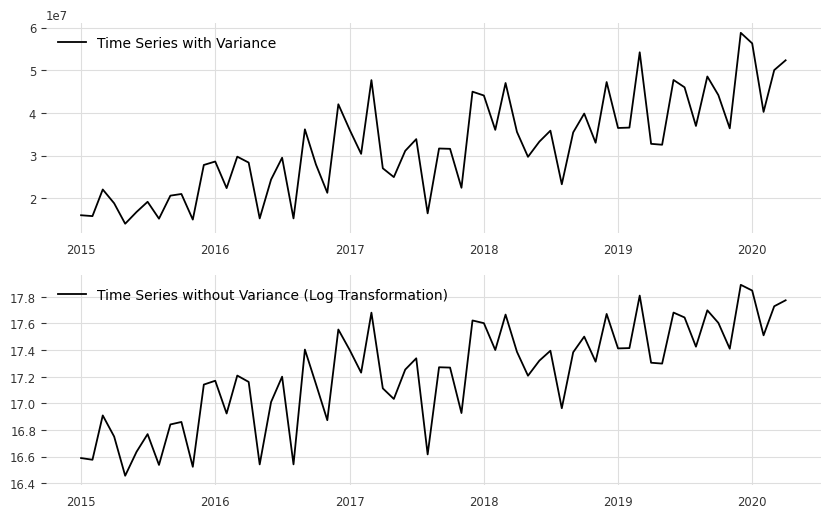

In [71]:
# Menghilangkan variance dengan transformasi log dan membandingkan dengan data awal
df_log = np.log(df)

plt.subplot(211)
plt.plot(df, label= 'Time Series with Variance')
plt.legend()
plt.subplot(212)
plt.plot(df_log, label='Time Series without Variance (Log Transformation)')
plt.legend()  
plt.show()

Transformasi log telah menghilangkan variance dari data. Data yang diubah ini akan digunakan untuk selanjutnya. 

Memeriksa kembali skor metode differencing dengan data transformasi log.

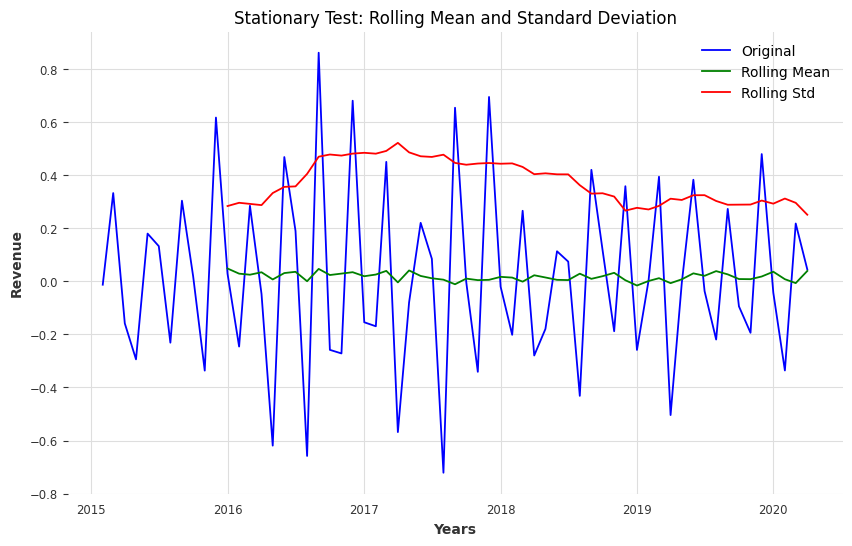

Results of Dickey-Fuller Test
Test Statistic                 -5.592816
p-value                         0.000001
#Lags Used                     10.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [72]:
df_log_diff = df_log.diff(periods = 1) # First order differencing

df_log_diff.dropna(inplace = True)# Data transformation may add na values
stationarity_test(df_log_diff)

Tes statistics lebih kecil dari Critical Value (1%) 

#### Decomposition of Time Series

Let's now use the decomposition technique to deconstruct the log transformed time series data, so that we can check the stationarity using residual data.
Menggunakan teknik decomposition untuk membuat data log menjadi beberapa komponen, agar bisa cek stationarity menggunakan residual data.

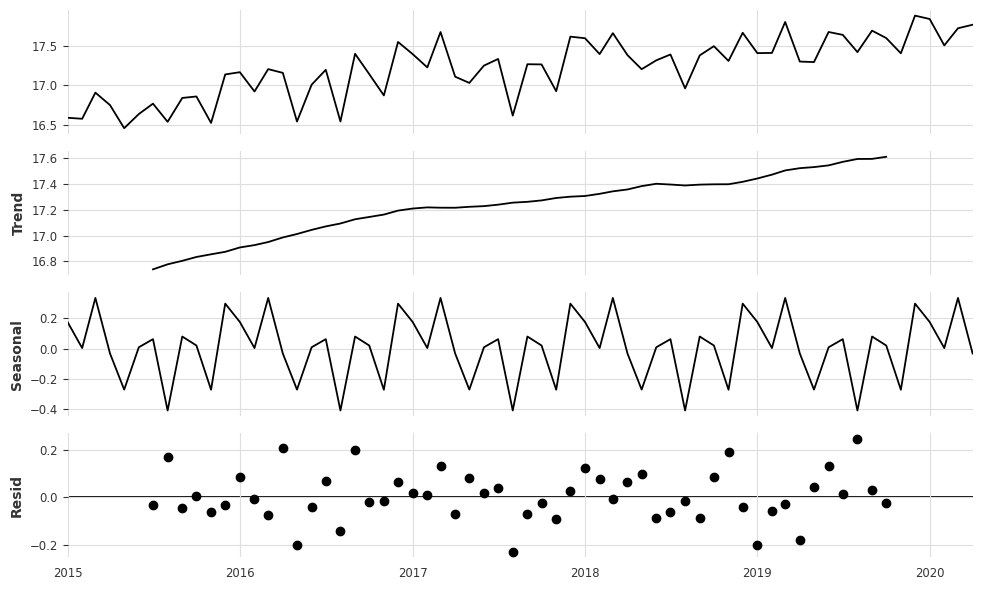

In [73]:
decomposition = sm.tsa.seasonal_decompose(df_log,period =12)
fig = decomposition.plot()
plt.show()

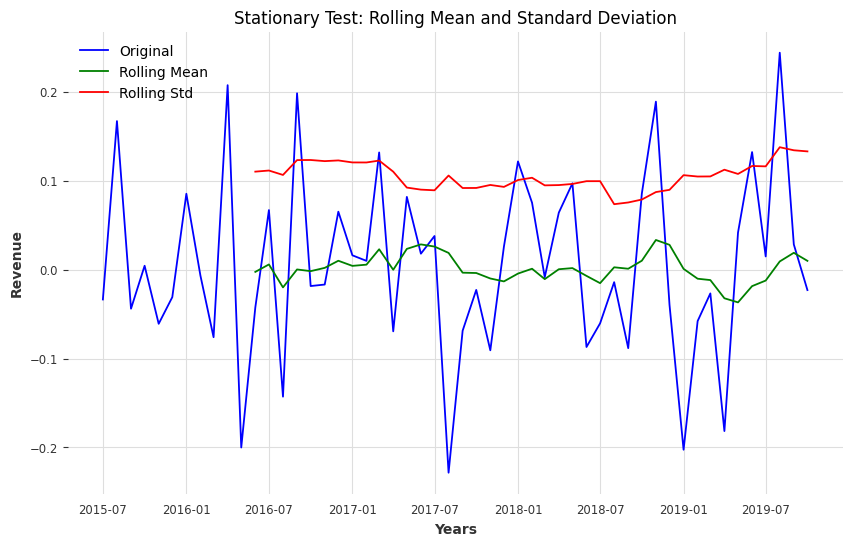

Results of Dickey-Fuller Test
Test Statistic                 -4.393586
p-value                         0.000305
#Lags Used                      4.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [74]:
df_log_residual = decomposition.resid
df_log_residual.dropna(inplace = True)
stationarity_test(df_log_residual)

Sama seperti sebelumnya, Tes statistics lebih kecil dari Critical Value (1%) dan p-value mendekati 0. Data time series ini sudah stationary.

## Forecasting

In [75]:
#reset index month
df_ts = df.reset_index()
df_ts

,Date,Revenue
0,2015-01-01,1.601007e+07
1,2015-02-01,1.580759e+07
2,2015-03-01,2.204715e+07
3,2015-04-01,1.881458e+07
4,2015-05-01,1.402148e+07
...,...,...
59,2019-12-01,5.875647e+07
60,2020-01-01,5.628830e+07
61,2020-02-01,4.022524e+07
62,2020-03-01,5.002217e+07


In [76]:
#Membuat array untuk df_ts dengan kolom time = Date dan kolom value = Revenue
ts = TimeSeries.from_dataframe(df_ts, time_col = 'Date', value_cols = 'Revenue')

In [77]:
ts

<TimeSeries (DataArray) (Date: 64, component: 1, sample: 1)> Size: 512B
array([[[16010072.1195  ]],

       [[15807587.449808]],

       [[22047146.023644]],

       [[18814583.29428 ]],

       [[14021479.611678]],

       [[16783928.522112]],

       [[19161892.194872]],

       [[15204984.296742]],

       [[20603939.9751  ]],

       [[20992874.780136]],

...

       [[45992141.57398 ]],

       [[36933665.022   ]],

       [[48526260.1344  ]],

       [[44160416.1824  ]],

       [[36374956.4944  ]],

       [[58756473.6608  ]],

       [[56288300.87    ]],

       [[40225243.264   ]],

       [[50022165.2325  ]],

       [[52320692.9428  ]]])
Coordinates:
  * Date       (Date) datetime64[ns] 512B 2015-01-01 2015-02-01 ... 2020-04-01
  * component  (component) object 8B 'Revenue'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

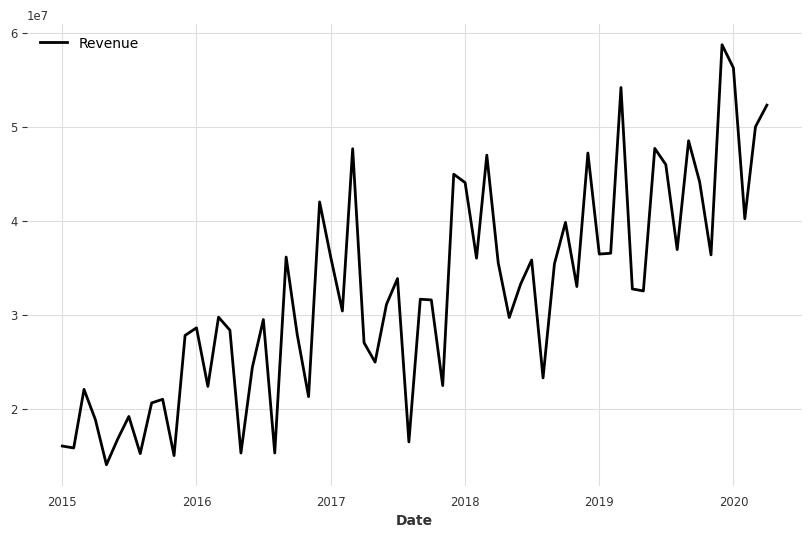

In [78]:
ts.plot()
plt.show()

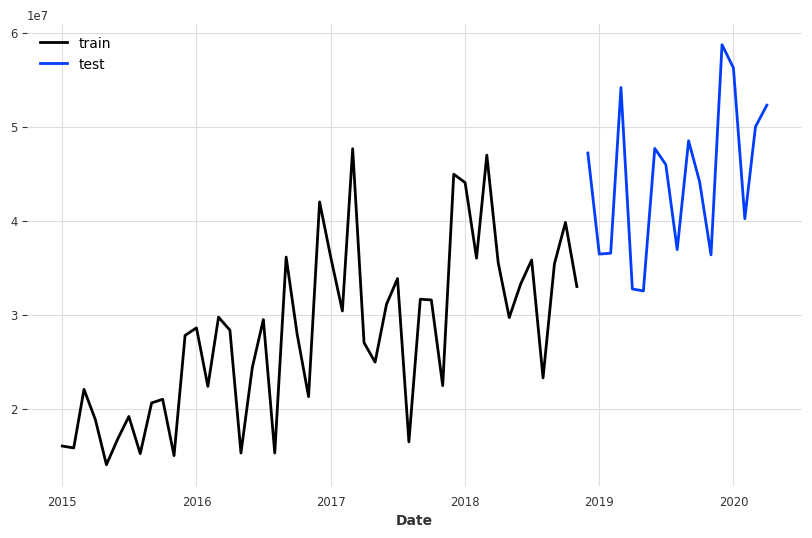

In [79]:
ts_train, ts_test = ts.split_before(0.75)
ts_train.plot(label = 'train')
ts_test.plot(label = 'test')
plt.show()

In [80]:
#function bernama evaluate untuk mengevaluasi prediksi dibanding data actual
def evaluate(actual_test, prediction):
    print(f'RMSE: {rmse(actual_test, prediction)}')
    print(f'R2: {r2_score(actual_test, prediction)}')
    print(f'MAPE: {mape(actual_test, prediction)}')

RMSE: 8708209.662306607
R2: -0.15491104543216272
MAPE: 15.042658308883784
Fitting the time series model takes 1.6713922023773193 seconds.


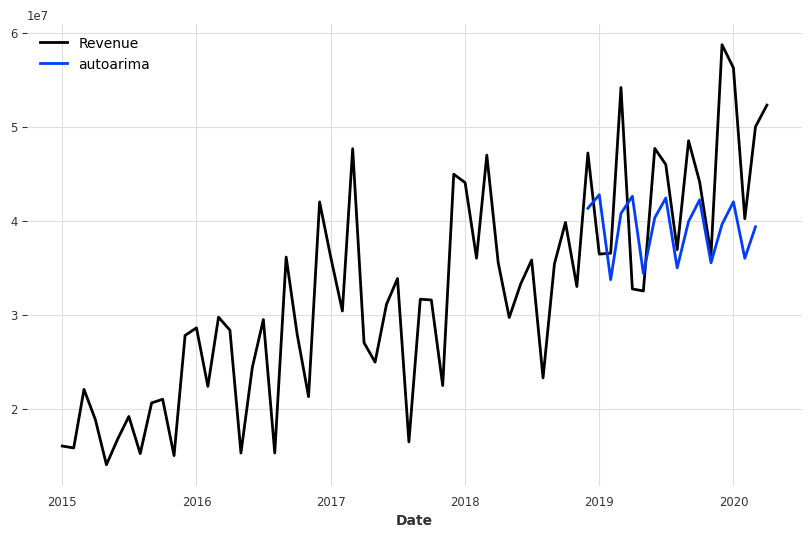

In [81]:
autoarima = AutoARIMA() #settingan default
start = time.time()
autoarima.fit(ts_train)
end = time.time()
autoarima_forecast = autoarima.predict(16) #angka 16 merupakan 25% data dari 64 baris

#evaluasi menggunakan evaluate
evaluate(ts_test, autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
autoarima_forecast.plot(label = 'autoarima')
plt.show()

In [82]:
new_autoarima = AutoARIMA(d=1, # berapa kali nge-differencing biar jadi seasonal, pada bahasan differencing diatas : df_log_diff = df_log.diff(periods = 1) # First order differencing
                          max_d=1, 
                          D=1, # periode differencing harus berapa periode seasonality
                          m=3, # periode seasonality
                          seasonal=True, # kita kasi tau kalo time series kita seasonal
                          max_order=10, # semakin tinggi angka ini, maka semakin banyak parameter pula yang dicari
                          stationary=False, # kita kasi tau kalo time series kita nggak stationary
                          suppress_warnings=False) # biar pas dia fitting modelnya ga banyak keluar output

RMSE: 7998671.502421149
R2: 0.025624167391842145
MAPE: 16.94066275021771
Fitting the time series model takes 1.230130672454834 seconds.


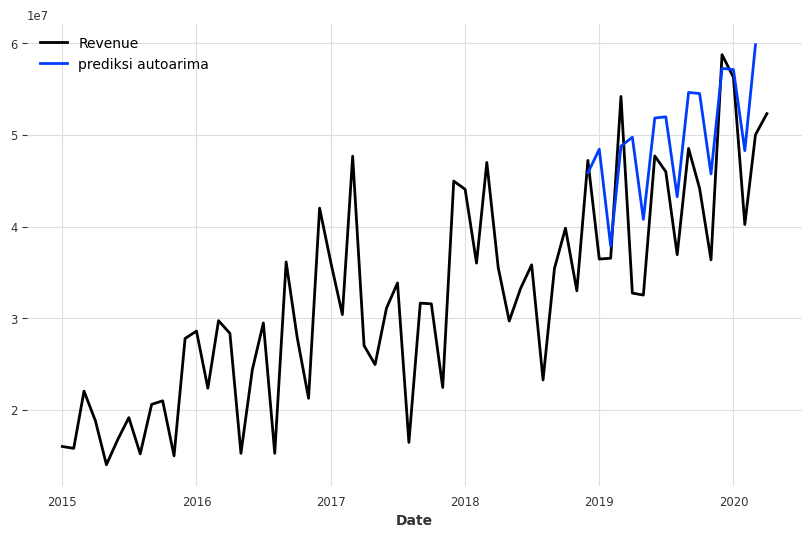

In [83]:
start = time.time()
new_autoarima.fit(ts_train) #fitting untuk mempelajari ts_train atau proses training
end = time.time()

new_autoarima_forecast = new_autoarima.predict(16) #prediksi pada 37 baris dataset masa depan (25% dari 144 baris di dataset Air Passenger)
evaluate(ts_test, new_autoarima_forecast)

print('Fitting the time series model takes', end - start, 'seconds.')
series.plot()
new_autoarima_forecast.plot(label = 'prediksi autoarima')
plt.show()

In [84]:
#reverse ts array to dataframe
predict_data = new_autoarima_forecast.pd_dataframe()
predict_data = predict_data.rename(columns={'Revenue': 'Prediction Value'})
predict_data.head()

component,Prediction Value
Date,
2018-12-01,4.585834e+07
2019-01-01,4.843889e+07
2019-02-01,3.788807e+07
2019-03-01,4.877066e+07
2019-04-01,4.974978e+07


In [85]:
#reverse ts array to dataframe
ts_test_data = ts_test.pd_dataframe()
ts_test_data.head()

component,Revenue
Date,
2018-12-01,4.722183e+07
2019-01-01,3.645996e+07
2019-02-01,3.654650e+07
2019-03-01,5.419871e+07
2019-04-01,3.274399e+07


In [86]:
df_predictions = pd.DataFrame(predict_data, columns=['Prediction Value'])
pd.concat([ts_test_data,df_predictions],axis =1).T

Date,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01
Revenue,4.722183e+07,3.645996e+07,3.654650e+07,5.419871e+07,3.274399e+07,3.253166e+07,4.770970e+07,4.599214e+07,3.693367e+07,4.852626e+07,4.416042e+07,3.637496e+07,5.875647e+07,5.628830e+07,4.022524e+07,5.002217e+07,5.232069e+07
Prediction Value,4.585834e+07,4.843889e+07,3.788807e+07,4.877066e+07,4.974978e+07,4.079045e+07,5.184388e+07,5.197470e+07,4.325985e+07,5.463553e+07,5.452142e+07,4.574304e+07,5.726369e+07,5.712468e+07,4.828468e+07,5.984143e+07,NaN


In [87]:
new_autoarima = AutoARIMA(d=1, # berapa kali nge-differencing biar jadi seasonal, pada bahasan differencing diatas : df_log_diff = df_log.diff(periods = 1) # First order differencing
                          max_d=1, 
                          D=1, # periode differencing harus berapa periode seasonality
                          m=3, # periode seasonality
                          seasonal=True, # kita kasi tau kalo time series kita seasonal
                          max_order=10, # semakin tinggi angka ini, maka semakin banyak parameter pula yang dicari
                          stationary=False, # kita kasi tau kalo time series kita nggak stationary
                          suppress_warnings=True, # biar pas dia fitting modelnya ga banyak keluar output 
                          error_action = 'trace', trace = True, information_criterion="bic") 

In [88]:
new_autoarima.fit(ts)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[3]             : BIC=2079.374, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[3]             : BIC=2083.310, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[3]             : BIC=2075.496, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[3]             : BIC=2066.320, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[3]             : BIC=2080.376, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[3]             : BIC=2070.165, Time=0.07 sec
 ARIMA(0,1,1)(0,1,2)[3]             : BIC=2070.005, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[3]             : BIC=2076.908, Time=0.02 sec
 ARIMA(0,1,1)(1,1,2)[3]             : BIC=2073.967, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[3]             : BIC=2068.568, Time=0.02 sec
 ARIMA(1,1,1)(0,1,1)[3]             : BIC=2067.620, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[3]             : BIC=2071.265, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[3]             : BIC=2065.553, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[3]             : BIC=2080.029, Time=0.01 sec
 ARIMA(1,1,0)(1,1,1)[3]          

AutoARIMA(add_encoders=None, d=1, max_d=1, D=1, m=3, seasonal=True, max_order=10, stationary=False, suppress_warnings=True, error_action=trace, trace=True, information_criterion=bic)

In [89]:
prediksi_di_masa_depan = new_autoarima.predict(24)

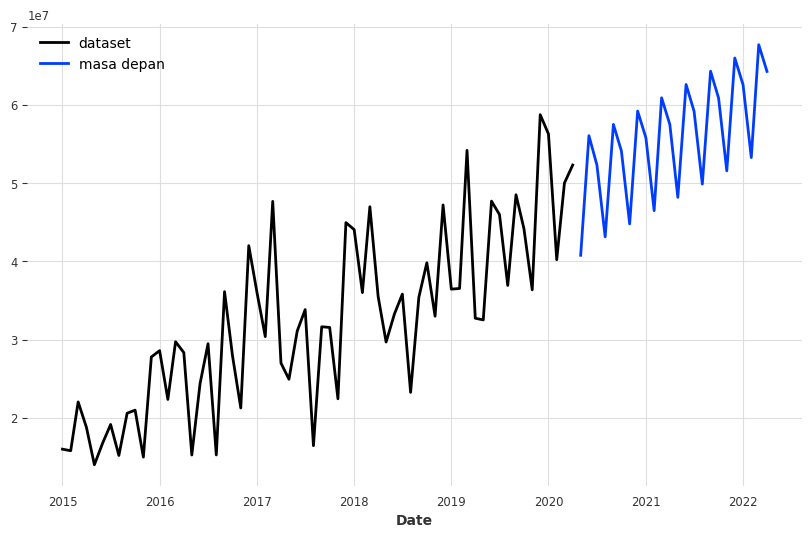

In [90]:
ts.plot(label = 'dataset')
prediksi_di_masa_depan.plot(label='masa depan')
plt.show()